# **[CMPE 295B] Using Convolutional Neural Network for Material Classification**
# **CNN-Softmax**
# Class 2

# Install/check Tensorflow 2.0

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install --upgrade pip

     |████████████████████████████████| 1.6MB 6.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [ ]:
pip install gast==0.3.3

In [ ]:
!pip install -q tensorflow-gpu==2.4.1  #(optional, the default tensorflow1.15 (The final version of TensorFlow 1.x.) is installed, you can upgrade to tensorflow2.0)
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

     |████████████████████████████████| 394.3 MB 14 kB/s 
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow Version:  2.4.1
Keras Version:  2.4.0


# Load Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import tempfile
import shutil

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

import random
from scipy import ndarray
import math

# image processing library
import skimage as ski
from skimage import transform
from skimage import util
from skimage import io

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install patool

     |████████████████████████████████| 77 kB 2.9 MB/s 


In [ ]:
import patoolib
#unzip files from shared google drive
zip_file_path = "/content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_2nd_labels_REDO_200.zip"
patoolib.extract_archive(zip_file_path, outdir='_Images')

patool: Extracting /content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_2nd_labels_REDO_200.zip ...
patool: running /usr/bin/7z x -o_Images -- "/content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_2nd_labels_REDO_200.zip"
patool: ... /content/gdrive/Shareddrives/[CMPE295B] Using CNNs for Material Classification/3. Image Dataset/AUG_Material_images_2nd_labels_REDO_200.zip extracted to `_Images'.


'_Images'

In [ ]:
base_dir = "/content/_Images/content/_Images_split"

# Define train, valiation and test dataset

In [ ]:
# Define batch size
BATCH_SIZE = 32

In [ ]:
# Define image size for training
# image dimensions for VGG16 is 224, 224
IMAGE_SIZE = 224

# Use ImageDataGenerator to rescale the images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
    )

# Create the train generator and specify where the train dataset directory, image size, batch size.
train_generator = datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    #class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
    )

# Create the validation generator with similar approach as the train generator with the flow_from_directory() method.
val_generator = datagen.flow_from_directory(
    os.path.join(base_dir,'val'),
    #class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
    )

# Create the test generator with similar approach as the train generator with the flow_from_directory() method.
test_generator = datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
    )

Found 1200 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 49 images belonging to 6 classes.


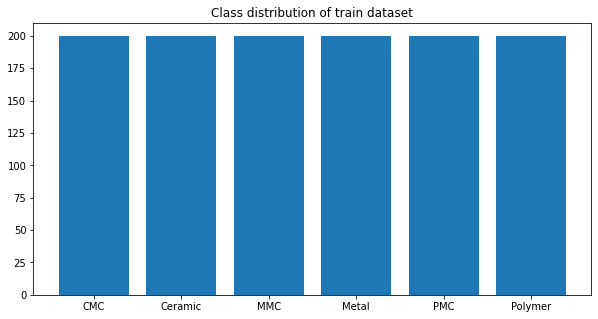

In [ ]:
from collections import OrderedDict
cls_train = train_generator.classes
classes = list(train_generator.class_indices.keys())

unique, counts = np. unique(cls_train, return_counts=True)
valdict = OrderedDict(zip(unique, counts))

num_values = []
for i in range(len(train_generator.class_indices)):
  num_values.append(valdict[i])

plt.figure(figsize=(10,5))
x = np.arange(len(num_values))
xlable = classes
plt.bar(x, num_values)
plt.xticks(x, xlable)
plt.title('Class distribution of train dataset')
plt.show()

# Model : Design CNN Model with Transfer Learning

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define image shape
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Define metrics
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='pre'),
      tf.keras.metrics.Recall(name='rec'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'auc', 'prc']
  plt.figure(figsize=(20, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True
    )

#### 1) Model Creation

In [ ]:
EPOCHS = 300

In [ ]:
def make_tfmodel_modi(lr, metrics=METRICS, output_bias=None):
  # base model output shape
  vgg16 = tf.keras.applications.VGG16(
      input_shape=IMG_SHAPE,
      pooling='avg',
      include_top=False,
      weights='imagenet')
  
  layer_name = 'block5_pool'
  base_model = Model(inputs=vgg16.input, outputs=vgg16.get_layer(layer_name).output)
  
  model = Sequential([base_model,
                      Conv2D(512, (3,3), activation='relu', padding='same'),
                      GlobalAveragePooling2D(),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(32, activation='relu'),
                      Dropout(0.2),
                      Dense(train_generator.num_classes, activation='softmax')
                      ])
  # frozen learnable parameters from VGG16
  model.layers[0].trainable = False

  model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy',
                metrics=metrics)

  return model

In [ ]:
model_vgg16_modi = make_tfmodel_modi(lr=1e-4)
model_vgg16_modi.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 512)         2359808   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)               

#### 2) Model Training

In [ ]:
history = model_vgg16_modi.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/300
38/38 [==============================] - 40s 998ms/step - loss: 1.7239 - tp: 1.0513 - fp: 0.1795 - tn: 3132.1282 - fn: 625.4103 - accuracy: 0.2888 - pre: 0.4222 - rec: 0.0010 - auc: 0.6266 - prc: 0.2787 - val_loss: 1.4840 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 300.0000 - val_fn: 59.0000 - val_accuracy: 0.4667 - val_pre: 1.0000 - val_rec: 0.0167 - val_auc: 0.8114 - val_prc: 0.5040
Epoch 2/300
38/38 [==============================] - 36s 940ms/step - loss: 1.4083 - tp: 56.2564 - fp: 5.8462 - tn: 3161.3333 - fn: 577.1795 - accuracy: 0.4378 - pre: 0.9414 - rec: 0.0865 - auc: 0.8203 - prc: 0.5035 - val_loss: 1.1930 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 299.0000 - val_fn: 52.0000 - val_accuracy: 0.6500 - val_pre: 0.8889 - val_rec: 0.1333 - val_auc: 0.8915 - val_prc: 0.6421
Epoch 3/300
38/38 [==============================] - 36s 935ms/step - loss: 1.1512 - tp: 138.2821 - fp: 25.7692 - tn: 3092.1795 - fn: 485.3077 - accuracy: 0.5771 - pre: 0.8381 - rec: 0.1996 - auc

#### 3) Model Evaluation

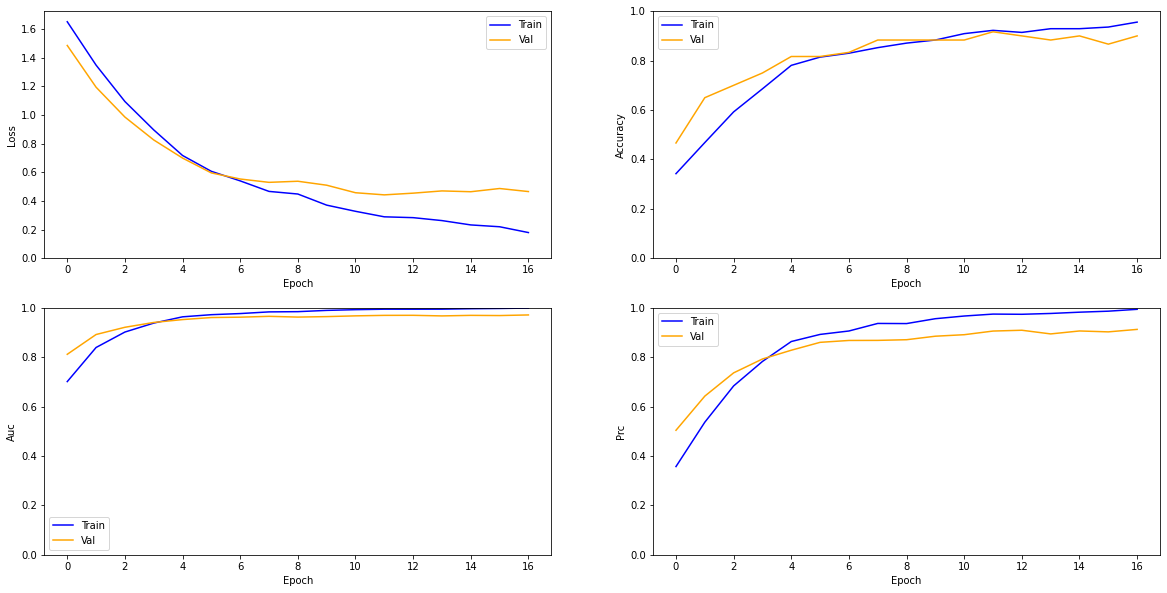

In [ ]:
plot_metrics(history)

In [ ]:
train_predictions_model = model_vgg16_modi.predict(train_generator)#, batch_size=BATCH_SIZE)
test_predictions_model = model_vgg16_modi.predict(test_generator)#, batch_size=BATCH_SIZE)

In [ ]:
print("Model results for Training dataset\n")

train_model_results = model_vgg16_modi.evaluate(train_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, train_model_results):
  print(name, ': ', value)

Model results for Training dataset

loss :  0.18494538962841034
tp :  1137.0
fp :  25.0
tn :  5975.0
fn :  63.0
accuracy :  0.9649999737739563
pre :  0.9784853458404541
rec :  0.9474999904632568
auc :  0.9985329508781433
prc :  0.9935659766197205


In [ ]:
print("Model results for Validation dataset\n")

val_model_results = model_vgg16_modi.evaluate(val_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, val_model_results):
  print(name, ': ', value)

Model results for Validation dataset

loss :  0.44227951765060425
tp :  53.0
fp :  3.0
tn :  297.0
fn :  7.0
accuracy :  0.9166666865348816
pre :  0.9464285969734192
rec :  0.8833333253860474
auc :  0.9690000414848328
prc :  0.9055172801017761


In [ ]:
print("Model results for Test dataset\n")

test_model_results = model_vgg16_modi.evaluate(test_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, test_model_results):
  print(name, ': ', value)

Model results for Test dataset

loss :  0.6577372550964355
tp :  42.0
fp :  4.0
tn :  241.0
fn :  7.0
accuracy :  0.8775510191917419
pre :  0.9130434989929199
rec :  0.8571428656578064
auc :  0.943356990814209
prc :  0.8715049624443054


In [ ]:
model_vgg16_modi.save('/content/model_vgg16_modi_1st_class.h5')

# Model: CNN Model with SVM

# Model Creation

In [ ]:
EPOCHS = 300

In [ ]:
from tensorflow.keras.regularizers import l2 # this is needed for SVM

In [ ]:
def make_tfmodel_modi(lr, metrics=METRICS, output_bias=None):
  # base model output shape
  vgg16 = tf.keras.applications.VGG16(
      input_shape=IMG_SHAPE,
      pooling='avg',
      include_top=False,
      weights='imagenet')
  
  layer_name = 'block5_pool'
  base_model = Model(inputs=vgg16.input, outputs=vgg16.get_layer(layer_name).output)
  
  model_svm = Sequential([base_model,
                          Conv2D(512, (3,3), activation='relu', padding='same'), 
                          GlobalAveragePooling2D(),
                          Dense(64, activation='relu'),
                          Dense(32, activation='relu'),
                          Dense(32, activation='relu'),
                          Dropout(0.2),
                          ])

  # adding SVM layer at output
  model_svm.add(Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
  model_svm.add(Activation('softmax')) # for multiclassification change activation to softmax
                                      # for Binary change activation to linear
  model_svm.layers[0].trainable = False

  model_svm.compile(loss='squared_hinge',     # for multiclassification change loss to squared_hinge
                    optimizer='adam',
                    metrics=['accuracy'])
  
  return model_svm

In [ ]:
model_vgg16_modi = make_tfmodel_modi(lr=1e-4)
model_vgg16_modi.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 512)         2359808   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________

In [ ]:
history = model_vgg16_modi.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=[early_stopping],
    validation_data=val_generator)

Epoch 1/300
38/38 [==============================] - 62s 1s/step - loss: 1.2481 - accuracy: 0.2584 - val_loss: 1.1525 - val_accuracy: 0.5167
Epoch 2/300
38/38 [==============================] - 40s 1s/step - loss: 1.1370 - accuracy: 0.4941 - val_loss: 1.0573 - val_accuracy: 0.7333
Epoch 3/300
38/38 [==============================] - 38s 987ms/step - loss: 1.0654 - accuracy: 0.6468 - val_loss: 1.0086 - val_accuracy: 0.7500
Epoch 4/300
38/38 [==============================] - 38s 1s/step - loss: 0.9862 - accuracy: 0.7828 - val_loss: 0.9864 - val_accuracy: 0.7667
Epoch 5/300
38/38 [==============================] - 38s 993ms/step - loss: 0.9813 - accuracy: 0.7729 - val_loss: 0.9508 - val_accuracy: 0.8500
Epoch 6/300
38/38 [==============================] - 37s 982ms/step - loss: 0.9401 - accuracy: 0.8563 - val_loss: 0.9360 - val_accuracy: 0.8500
Epoch 7/300
38/38 [==============================] - 37s 978ms/step - loss: 0.9089 - accuracy: 0.9038 - val_loss: 0.9385 - val_accuracy: 0.8333
E

In [ ]:
train_predictions_model = model_vgg16_modi.predict(train_generator)#, batch_size=BATCH_SIZE)
test_predictions_model = model_vgg16_modi.predict(test_generator)#, batch_size=BATCH_SIZE)

In [ ]:
print("Model results for Training dataset\n")

train_model_results = model_vgg16_modi.evaluate(train_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, train_model_results):
  print(name, ': ', value)

Model results for Training dataset

loss :  0.8336829543113708
accuracy :  1.0


In [ ]:
print("Model results for Validation dataset\n")

val_model_results = model_vgg16_modi.evaluate(val_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, val_model_results):
  print(name, ': ', value)

Model results for Validation dataset

loss :  0.8901293277740479
accuracy :  0.9166666865348816


In [ ]:
print("Model results for Test dataset\n")

test_model_results = model_vgg16_modi.evaluate(test_generator, verbose=0)

for name, value in zip(model_vgg16_modi.metrics_names, test_model_results):
  print(name, ': ', value)

Model results for Test dataset

loss :  0.9029205441474915
accuracy :  0.8979591727256775


In [ ]:
model_vgg16_modi.save('/content/model_vgg16_modi_1st_class.h5')